# Independent Component Analysis (ICA)

Copyright (c) 2019 OERCompBiomed (UiB)

Independent component analysis is a decomposition technique used to identify independent sources from a mixture (or rather multiple mixes) of signals - a procedure known as blind source separation. For instance, when you find yourself at a party, your ears will receive a single concoction of sounds from a whole array of sources, tens of people speaking, music on the speakers, and sounds of laughter. Although it happens automatically, the work done by our brains is not a trivial task - build a model of the independent signal in order for you to filter out everything unnecessary so you can focus on your conversation.

ICA works similarly: provided a few samples of mixed signal, it can give you (an approximation of) the constituent sources. Here we will use the example of images for illustration. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import FastICA

In [109]:
# avoid endless sequences of digits when printing...
np.set_printoptions(precision=2) 

#### Provided a mixture of signals, are you able to separate them into the originals?

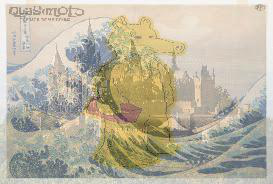

In [3]:
Image.open('assets/blended.jpg')

Perhaps it becomes easier if you are given more than one mixture. This is exactly what ICA does.

### Load images with PIL

In [4]:
filenames = ['assets/castle.jpg', 'assets/quas.jpg', 'assets/wave.jpg']
im1,im2,im3 = [Image.open(fn) for fn in filenames]

In [5]:
# image dimensions
for im in (im1,im2,im3):
    print(im.size)

(1200, 900)
(1200, 1200)
(273, 184)


#### Resize all images to the same size

In [6]:
imgs = (im1,im2,im3)
smallest_index = np.argmin([np.prod(im.size) for im in imgs])

In [7]:
print(smallest_index)

2


#### Exercise 1. Given this information, resize all images to fit the smallest image.
Hint: use the Tab trick to find the necessary method.

In [8]:
# %load solutions/ex3_1.py
# resize according to smallest image
sz = imgs[smallest_index].size
im1 = im1.resize(sz)
im2 = im2.resize(sz)

In [9]:
# should print 3 identical tuples
for im in (im1,im2,im3):
    print(im.size)

(273, 184)
(273, 184)
(273, 184)


#### Display images

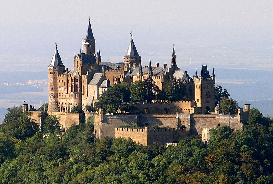

In [378]:
im1

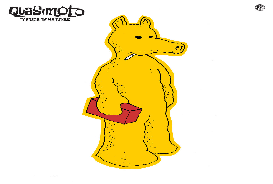

In [11]:
im2

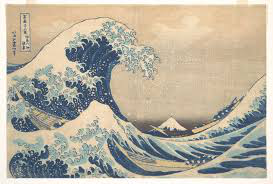

In [12]:
im3

### Greyscale for simplicity

In [13]:
from PIL import ImageOps
gim1,gim2,gim3 = [ImageOps.grayscale(im) for im in (im1,im2,im3)]

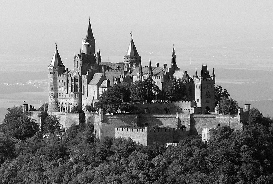

In [14]:
gim1

### Reshape and stack the images

ICA requires our whole dataset to be fed as a (NxD) matrix, in which each image is a column.

In [15]:
S = []
for i, pic in enumerate((gim1,gim2,gim3)):
    s = np.ravel(pic) # flattens image into a long vector
    S.append(s)
    
S = np.asarray(S).T

In [16]:
S.shape # 3 images, each of which has 50232 pixels

(50232, 3)

In [17]:
S

array([[221, 255, 251],
       [221, 255, 250],
       [224, 255, 251],
       ...,
       [ 10, 255, 241],
       [ 18, 255, 238],
       [  8, 255, 239]], dtype=uint8)

## Make linear combination of images

Now we make linear combinations of the images. We do it 4 times obtaining 4 mixtures (imagine having 4 microphones in a room with 3 people talking in eachother's mouth).

#### Exercise 2. Make 4 new images `X`, each of which is a linear combination of the source images. 
Hint: use `numpy.random.randn` to make a random matrix. `@` is the matrix multiplication operator.

If you are not familiar with linear algebra: https://mathinsight.org/matrix_vector_multiplication

The final shape of X should be (50232x4)

In [113]:
# %load solutions/ex3_2.py
# mixing matrix
np.random.seed(42)
A = np.random.randn(4,3)

print(A.T)

# apply transformation
X = S @ A.T

# EXPLANATION:
# each column in A.T defines one of the linear combinations (4 in total)
# the rows define how much to add from each source. 
# E.g. the first combination will be (0.5*im1 - 0.14*im2 + 0.65*im3)

[[ 0.5   1.52  1.58  0.54]
 [-0.14 -0.23  0.77 -0.46]
 [ 0.65 -0.23 -0.47 -0.47]]


In [114]:
X.shape

(50232, 4)

In [115]:
#image = Image.blend(im1, im2, .5)
#image = Image.blend(image, im3, .5)
#image.save('blended.jpg')

#### Display the linear combinations

In [116]:
scaler = MinMaxScaler(feature_range=(0, 255))

# our images are currently strecthed out, so we must reshape them.
def plot(X, i):
    m1 = X[:,i]
    m1 = scaler.fit_transform(m1.reshape(-1,1))
    plt.imshow(m1.reshape(sz[::-1]), cmap='gray'); plt.show()

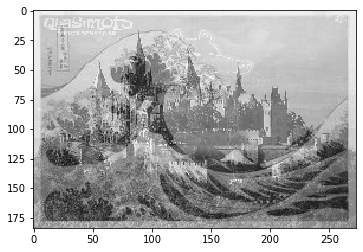

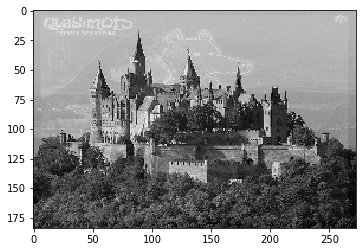

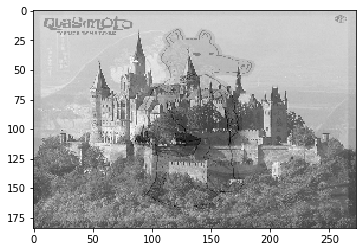

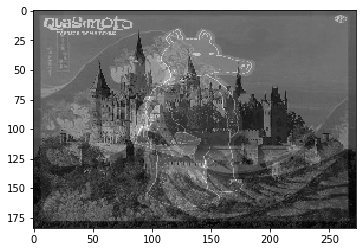

In [117]:
for i in range(A.shape[0]): plot(X, i)

The above is all our algorithm will be able to see. It has no gain to the original separated images.

#### Rescale the images before doing ICA
Standardizing is a necessary step prior to many ML algorithms 

In [118]:
np.mean(X), np.std(X)

(109.68562892340829, 178.54428368042838)

In [119]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [120]:
np.mean(X), np.std(X)
# now we have mean 0 and variance 1

(6.78970602733015e-17, 1.0000000000000013)

## Do the ICA
We use scikit-learn's implementation `FastICA`

In [379]:
ica = FastICA(n_components=3, random_state=1)
S_ = ica.fit_transform(X)  # estimated sources
#A_ = ica.mixing_  # estimated mixing matrix

### Inspect the reconstructions

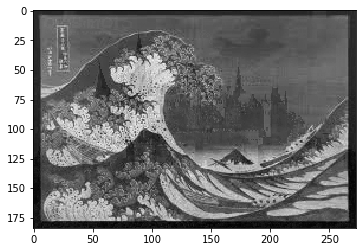

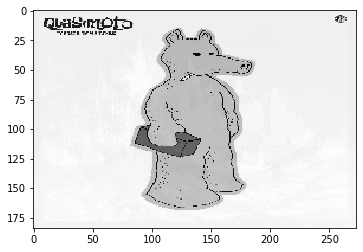

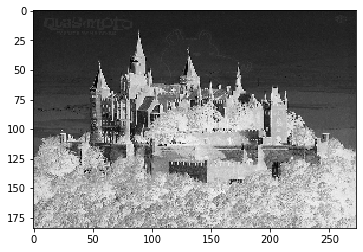

In [380]:
for i in range(3): plot(S_,i)

### And compare them to the originals

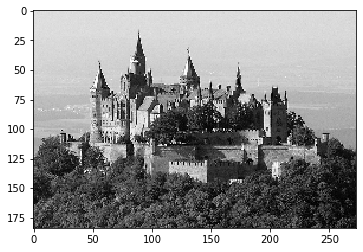

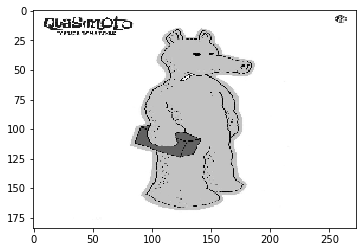

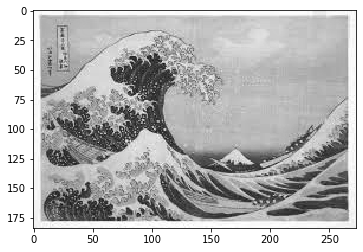

In [381]:
for i in range(3): plot(S,i)

You may experience that the reconstructions have inverted colors to the original. This is a feature of ICA that it cannot discern the sign. So ignoring this artifact, how did the algorithm do? Are they seperated well enough?

In [28]:
### experiment: can you reapply it to yield even better results?

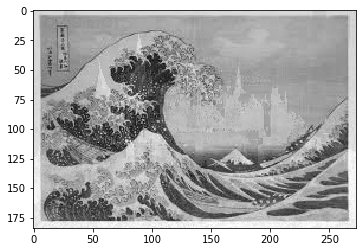

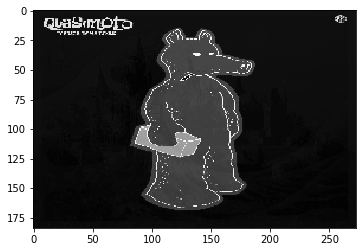

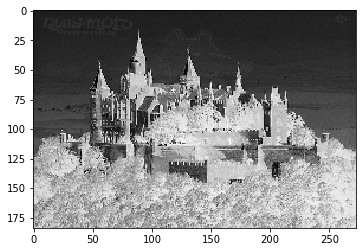

In [29]:
ica = FastICA(n_components=3, random_state=0, fun='logcosh')
S_ = ica.fit_transform(S_)  # estimated sources
for i in range(3): plot(S_, i)

ICA can be done for any type of data: visual, time series, tabular data. The only requirement is for the data to be fed into the algorithm in a given shape. In practice, ICA is used in denoising, and for identifying independent brain networks from fMRI and EEG scans.

In [30]:
# TODOG: figures to explain the math

# ICA and Neuroscience 

One of the most relevant medical use cases for ICA is in functional brain imaging. ICA is used both for EEG/MEG recordings as well as fMRI: any time series data of assumed overlapping signals. Especially EEG is spacially unspecific (signals are very "leaky"), such that any measured point is a combination of signals from various regions. In resting state (i.e. subjects are resting and not doing any particular task) fMRI it is used to derive spatial maps (independent components, ICs) which we refer to as resting state networks. Despite being identified from subjects at rest, these spatially continuous maps correspond largely to functionally coherent systems, such as the early visual system, the sensorimotor system etc. 


<img src="assets/Beckmann_2012.png" />

In ICA for neurimaging much goes on behind the scenes. For instance, individual subjects' datasets are concatenated and run through a PCA before doing ICA. This is to obtain a group consensus of ICs of subjects giving a more robust result, and PCA for computational efficiency. The essential concept is nonetheless the same as above.

In [44]:
import nilearn # library for neuroimaging
from nilearn import datasets
from nilearn.decomposition import CanICA # ICA for 4D neuroimaging data

In [33]:
print(nilearn.__version__)

0.7.0


#### We will download the brain development dataset
Curtesy of *Richardson, H., Lisandrelli, G., Riobueno-Naylor, A., & Saxe, R. (2018).
Development of the social brain from age three to twelve years.
Nature communications, 9(1), 1027.
https://www.nature.com/articles/s41467-018-03399-2*

In [34]:
# bug in nilearn v0.6.0, update to 0.7.0
ds = datasets.fetch_development_fmri(n_subjects=20)

 ...done. (3 seconds, 0 min)


Downloaded 4202496 of 5642698 bytes (74.5%,    0.4s remaining) ...done. (6 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (5 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


Downloaded 4202496 of 6225801 bytes (67.5%,    0.6s remaining) ...done. (5 seconds, 0 min)


 ...done. (2 seconds, 0 min)


Downloaded 4202496 of 6232787 bytes (67.4%,    0.6s remaining) ...done. (5 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (4 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (3 seconds, 0 min)


 ...done. (2 seconds, 0 min)


 ...done. (3 seconds, 0 min)


In [36]:
dir(ds)

['confounds', 'description', 'func', 'phenotypic']

In [42]:
# a list of the paths to the nifti files
func_fn = ds.func
func_fn[:3]

['C:\\Users\\Peder/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'C:\\Users\\Peder/nilearn_data\\development_fmri\\development_fmri\\sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'C:\\Users\\Peder/nilearn_data\\development_fmri\\development_fmri\\sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

### Confounding variables
The confounds are variables in the data, such as subject head motion, which may be a source of noise. We will use this later when training the model in order to regress out these uninteresting variations.

In [74]:
confounds = ds.confounds

In [70]:
# initialize
canica = CanICA(n_components=20,
                memory="nilearn_cache", memory_level=2,
                verbose=10,
                mask_strategy='template',
                random_state=0)

In [71]:
# fit (remember to pass in confounds)
canica.fit(func_fn, confounds=confounds)

[MultiNiftiMasker.fit] Loading data from [C:\Users\Peder/nilearn_data\development_fmri\development_fmri\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz, C:\Users\Peder/nilearn_data\development_fmri\development_fmri
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[CanICA] Loading data
[Memory]0.0s, 0.0min    : Loading randomized_svd from nilearn_cache\joblib\sklearn\utils\extmath\randomized_svd\a32535f6fa103d8f13bfe3c17dc28df9
______________________________________randomized_svd cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading fastica from nilearn_cache\joblib\sklearn\decomposition\_fastica\fastica\3b56ac9bd315b9c941b2a202d2bd7949
_____________________________________________fastica cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading fastica from nilearn_cache\joblib\sklearn\decomposition\_fastica\fastica\ac0cc86228347bac48f4157810cd951c
_____________________________________________fastica cache loaded 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


_____________________________________________fastica cache loaded - 0.0s, 0.0min


CanICA(detrend=True, do_cca=True, high_pass=None, low_pass=None, mask=None,
       mask_args=None, mask_strategy='template',
       memory=Memory(location=nilearn_cache\joblib), memory_level=2,
       n_components=20, n_init=10, n_jobs=1, random_state=0, smoothing_fwhm=6,
       standardize=True, t_r=None, target_affine=None, target_shape=None,
       threshold='auto', verbose=10)

The spatial components (ICs) are obtained both as a raw numpy matrix and stored as a full collection of the data including metadata (specifically the class `nibabel.nifti1.Nifti1Image`, which is not too important)

In [127]:
print(canica.components_img_)

<class 'nibabel.nifti1.Nifti1Image'>
data shape (50, 59, 50, 20)
affine: 
[[   4.    0.    0.  -96.]
 [   0.    4.    0. -132.]
 [   0.    0.    4.  -78.]
 [   0.    0.    0.    1.]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 50 59 50 20  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [1. 4. 4. 4. 1. 1. 1. 1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
qu

In [129]:
canica_components_img = canica.components_img_

#canica_components_img.to_filename('canica_resting_state.nii.gz')

In [130]:
canica_components_img

## Visualize the ICs

C:\Users\Peder\Anaconda3\envs\cbm101\lib\site-packages\nilearn\plotting\displays.py:99: UserWarning: No contour levels were found within the data range.
  **kwargs)
C:\Users\Peder\Anaconda3\envs\cbm101\lib\site-packages\nilearn\plotting\displays.py:99: UserWarning: linewidths is ignored by contourf
  **kwargs)
C:\Users\Peder\Anaconda3\envs\cbm101\lib\site-packages\numpy\ma\core.py:2786: UserWarning: Warning: converting a masked element to nan.
  order=order, subok=True, ndmin=ndmin)


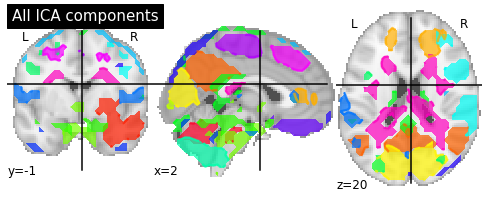

In [77]:
from nilearn.plotting import plot_prob_atlas

# Plot all ICA components together
plot_prob_atlas(canica_components_img, title='All ICA components')

In [124]:
canica_components_img.get_fdata().shape

(50, 59, 50, 20)

## visualize each component individually

C:\Users\Peder\Anaconda3\envs\cbm101\lib\site-packages\nilearn\plotting\displays.py:1609: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


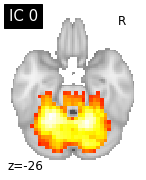

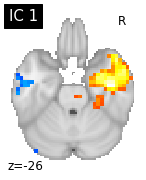

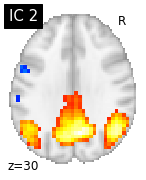

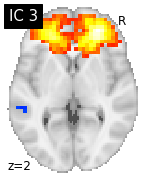

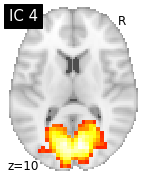

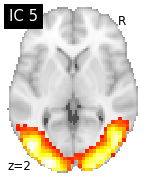

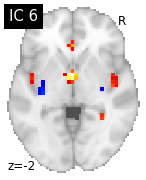

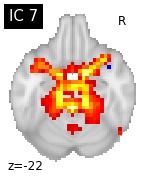

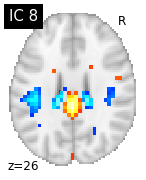

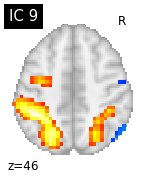

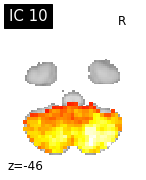

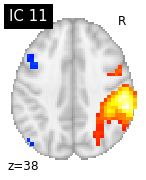

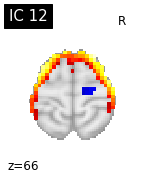

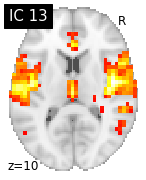

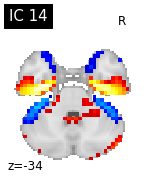

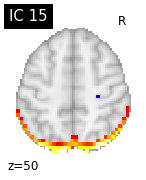

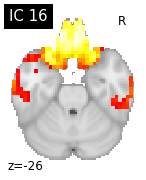

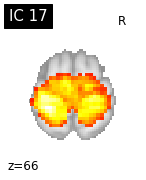

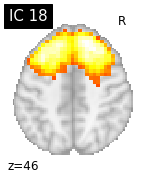

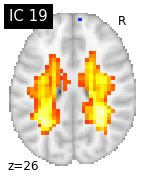

In [125]:
from nilearn.image import iter_img # this function deals with iterating through neuroimaging data
from nilearn.plotting import plot_stat_map, show

for i, cur_img in enumerate(iter_img(canica_components_img)):
    plot_stat_map(cur_img, display_mode="z", title="IC %d" % i,
                  cut_coords=1, colorbar=False)

### Interpretation
Each IC map is often referred to as a resting-state network (RSN), some of which are consistently identified across cohorts and datasets, others more spurious. One drawback here is that a lot of expertise and interpretation is needed to identify the components. Generally there is a high degree of bilateral symmetry - a good sign because many brain functions are largely coordinated between equivalent regions in the right and left hemisphere. 

Some of the components are even "noise" components. These components would have to be discarded prior to any further analysis. In general, the quality of the decompositions improve when we increase the dataset.


One of the benefits of ICA compared to other methods in functional connectivity is that it is purely data-driven, meaning it does not rely on any *a priori* anatomical brain segmentation for region extraction.

## Understanding the output
The data is stored as an N-D array, and can be thought of a collection of 3D volumes, one for each ICA. 

In [327]:
canica_components_img.shape

(50, 59, 50, 20)

In [328]:
data = canica_components_img.get_fdata()

### Inspect a single IC

In [329]:
np.set_printoptions(3)

In [330]:
# inspect a single IC
ic2 = data[...,2]

In [331]:
affine = canica_components_img.affine

In [332]:
print(ic2.shape); print(affine.shape)

(50, 59, 50)
(4, 4)


In [333]:
affine

array([[   4.,    0.,    0.,  -96.],
       [   0.,    4.,    0., -132.],
       [   0.,    0.,    4.,  -78.],
       [   0.,    0.,    0.,    1.]])

In [334]:
canica_components_img.dataobj.shape

(50, 59, 50, 20)

In [335]:
from nilearn.image import resample_img
import nibabel

# convert np.array to niftiimage so it can be read by nilearn
img = nibabel.Nifti1Image(ic2[:, :, :, np.newaxis], affine=affine)

img_in_mm_space = resample_img(img, target_affine=affine,
                               target_shape=ic2.shape)

C:\Users\Peder\Anaconda3\envs\cbm101\lib\site-packages\nilearn\plotting\displays.py:1609: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  fraction * (x1 - x0), y1 - y0])


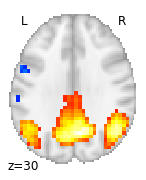

In [336]:
plot_stat_map(img_in_mm_space, display_mode="z",
                  cut_coords=1, colorbar=False)

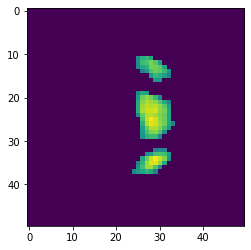

In [342]:
plt.imshow(ic2[:,16,:])

array([[0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.012],
       [0.   , 0.   , 0.014, 0.016, 0.02 ],
       [0.   , 0.017, 0.022, 0.026, 0.029]])

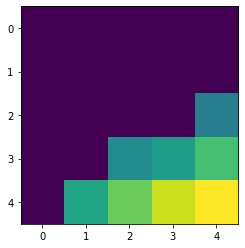

In [355]:
# zoom in  to see how the data is represented
region = ic2[:,16,:][30:35, 25:30]
plt.imshow(region)
region

This type of data we refer to a probabilistic map: it is not a binary assignment to each voxel of whether it belongs to an IC or not, but a continuous value. 

### Get the timeseries (*activity*) of the components

In this particular algorithm *CanICA*, we do not get the timeseries for each component. We can however bypass this by using the ICs as probabilistic maps and extract the regions this way. Other fMRI software analysis packages, like FSL will provide the timeseries as well.

In [364]:
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=canica_components_img, standardize=True)

In [365]:
func_fn[0]

'C:\\Users\\Peder/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz'

In [371]:
# get timeseries for subject 0
j=0
ts = masker.fit_transform(func_fn[j], confounds=confounds[j])

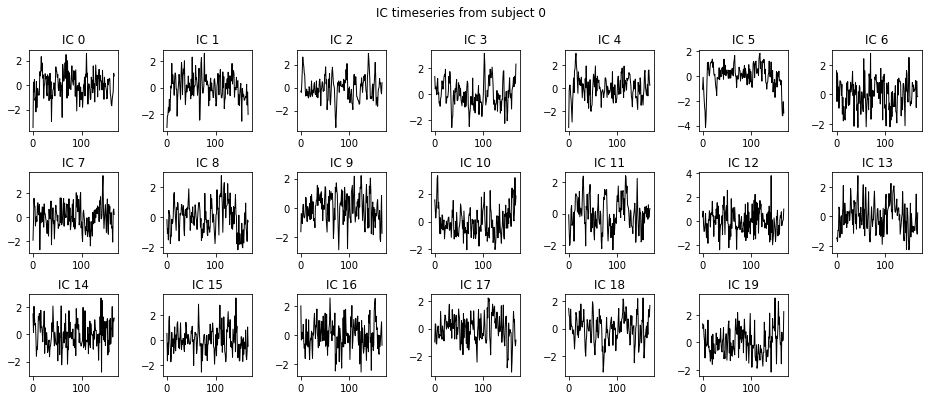

In [372]:
def plot_timeseries(ts):
    fig = plt.figure(figsize=(16,6))
    fig.suptitle('IC timeseries from single subject')
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    
    
    for ic in range(ts.shape[1]):
        ax=fig.add_subplot(3,7,ic+1)
        ax.plot(ts[:,ic], c='k', linewidth=1)
        plt.title(f"IC {ic}", loc='center')
        
plot_timeseries(ts)

In [368]:
# get timeseries for subject 2
j=2
ts = masker.fit_transform(func_fn[j], confounds=confounds[j])

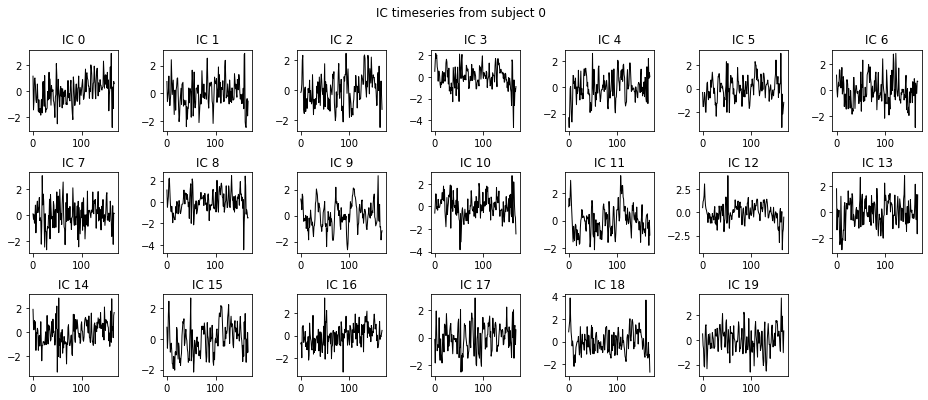

In [370]:
plot_timeseries(ts)

In [204]:
#for i, cur_img in enumerate(iter_img(canica_components_img)):
#    print(cur_img.)

## Further reading


- [Modelling with independent components](https://pubmed.ncbi.nlm.nih.gov/22369997/)
- [A group model for stable multi-subject ICA on fMRI datasets](https://www.sciencedirect.com/science/article/abs/pii/S1053811910001618)
- [Independent component analysis: algorithms and applications](https://www.sciencedirect.com/science/article/abs/pii/S0893608000000265)